# Sentiment analysis on the Amazon review dataset, using K-Nearest Neighbor Classifier

We begin by importing the various libraries and functions we will need.

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import pickle
import time
import timeit

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

Note that we are importing a previously processed csv file. But due to KNN algorithm we select only some part of the data.

In [32]:
# Importing data start timer
print('Importing data')
start = timeit.default_timer()

data_train = pd.read_csv('data/amazon_clean_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/amazon_clean_test.csv', encoding='utf-8')
data_train = data_train[:200000]
data_test = data_test[:40000]
# Importing data stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)


Importing data
Time:  15.999701399996411


We now need to vectorize our data. Here we need to explain some aspects of what we are doing. 

The CountVectorizer was used both to prepare the strings, but also to strip away some useless data (that caused clutter in the dataset). The exact values were found through a bit of trial and error.

The reason we use apply(lambda x: np.str_(x)) is that we had occasional problems where, in spite of our efforts, we found that sometimes a line in the dataset was not recognised as a string. We found that the apply lambda function was a quick and easy way to get around this problem.

In [33]:

data_train.Label.value_counts()
data_test.Label.value_counts()

#tf_idf_cv = TfidfVectorizer()
tf_idf_cv = TfidfVectorizer(min_df = 25, max_df = 0.8,
                    max_features = None, sublinear_tf = True, use_idf = True)

In [34]:
print('Fitting vectors')
start = timeit.default_timer()
trainX = tf_idf_cv.fit_transform(data_train['Review']
                                 .apply(lambda x: np.str_(x)))
testX = tf_idf_cv.transform(data_test['Review']
                            .apply(lambda x: np.str_(x)))
testY = data_test['Label'].values.astype(int)
trainY = data_train['Label'].values.astype(int)
# Fitting vectors stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)

Fitting vectors
Time:  10.435124900002847


## Dimensional reduction

We have one problem with using scipy's LDA and QDA, which is that both these systems require dense matrices. However our fit was made using TfidfVectorizer which outputs a sparse matrix (as does CountVectorizer). Further if we try to expand this matrix into a dense one we end up requiring over a TiB of memory.

Simply picking a limited number of max_features for TfidfVectorizer is also unsatisfactory, since we do not know how good they'd be at predicting.

Therefore we need to reduce the dimensions (dimension reduction by way of PCA, or just referred to as PCA below). We pick 200 as the proper number of dimensions because this would require a substantial, but surmountable, amount of RAM. Further we pick n_iter=7 and random_state=42 because that is what was on the code snippet at the webpage documenting this function.

Because we use a sparse matrix we are unable to use normal SVD and instead use a function called TruncatedSVD which can handle sparsematrices and returns a dense matrix.

In [35]:
print('Creating SVD')
start = timeit.default_timer()
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd.fit(trainX, trainY)
stop = timeit.default_timer()
print('Time: ', stop - start)

Creating SVD
Time:  36.49200759999803


In [36]:
print('PCA on training set')
start = timeit.default_timer()
trainXpca = svd.transform(trainX)
stop = timeit.default_timer()
print('Time: ', stop - start)

PCA on training set
Time:  0.8172629000036977


In [37]:
print('PCA on test set')
start = timeit.default_timer()
testXpca = svd.transform(testX)
stop = timeit.default_timer()
print('Time: ', stop - start)

PCA on test set
Time:  0.1765218999935314


## Nearest-Neighbor Classifier(KNN)

There is two type learners alongside the classifier: first one is eager learners and second one is lazy learners. KNN is an example for lazy learners which could be used to determine the class label of the test example. The justification for using nearest neighbors  is best exemplified by the following saying:  “If it walks like a duck, quacks like a duck, and looks like a duck, then it’s probably a duck.” (Tan,2014)
This classifier assume each example as a data in a d-dimensional space where d is the number of attributes. Also, another confusing points for this classifiers chosing number of nearest neighbor which is k. If k is too small, so classifier susceptible to overfitting because of noise in the training data. If k is too high, so classifier could misclassify the test values.Optimum value for k is generally is sqrt of number of sample in train set. See below figure as an example.


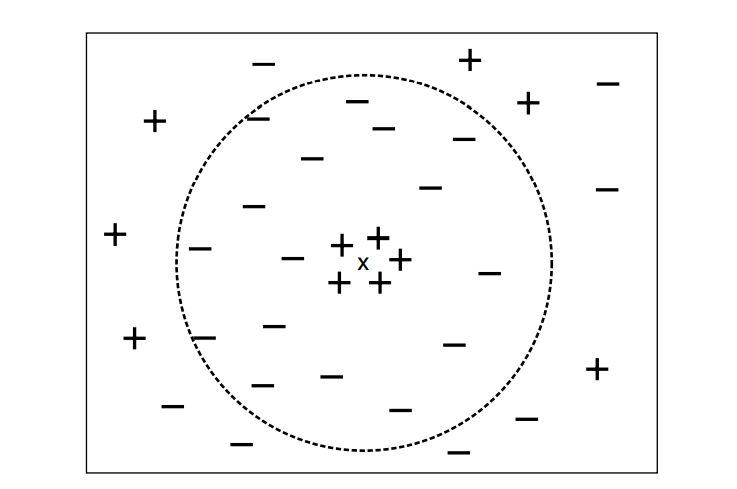

Fig. 1: k-nearest neighbor classification with k-diameter(Tan,2014).

**Algorithm:**


This algorithm calculates distance between each test data points(z = (x’,y’)) and all training data points(x,y) and create nearest neighbor list, Dz. And it is obvious that if train set is so big, process could cost a lot.


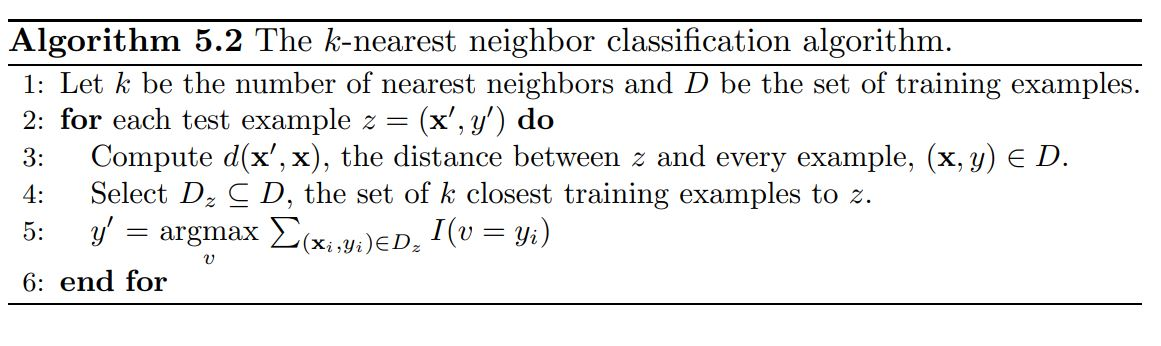

Fig.2: Algorithm of KNN classifier(Tan,2014).

After Dz obtained, voting process applied:

$$
\text { Majority Voting: } y^{\prime}=\underset{v}{\operatorname{argmax}} \sum_{\left(\mathbf{x}_{i}, y_{i}\right) \in D_{z}} I\left(v=y_{i}\right)
$$

Where:


v: class label
	Yi: class label for one of the nearest neighbors,
	I( ): is an indicator function that returns the value 1 if its argument is true and 0 otherwise

In this approach all data points have same effect on classification. So, this makes algorithm to sensitive to k values. Using weight influence of each data point according to distance, wi=1/d(x’,xi)^2. Far data points have less impact:

$$
\text { Distance-Weighted Voting: } y^{\prime}=\underset{v}{\operatorname{argmax}} \sum_{\left(\mathbf{x}_{i}, y_{i}\right) \in D_{z}} w_{i} \times I\left(v=y_{i}\right)
$$


#### Running KNN classifier with 5k train data and 1k test data in order to observe effect of K.

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [12]:
k_arr = []
accu_arr = []
f1_arr = []
start = timeit.default_timer()
for K in np.arange(1,1052,10):
    ## KNN
    # Start timer    
    KNNclass = KNeighborsClassifier(n_neighbors=K, algorithm='kd_tree',
                                    weights='uniform', n_jobs=4)
    KNNclass.fit(trainXpca, trainY)
    y_pred = KNNclass.predict(testXpca)
    # stop timer
    
   
    # Printing results
    accuracy = 100*accuracy_score(testY,y_pred)
    f1= 100*f1_score(testY,y_pred)
    k_arr.append(K)
    accu_arr.append(accuracy)
    f1_arr.append(f1)
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  109.68032210000092


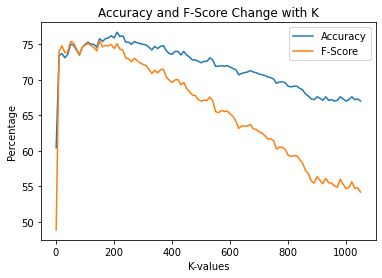

In [17]:
k_arr = np.array(k_arr)
accu_arr= np.array(accu_arr)
f1_arr = np.array(f1_arr)
plt.plot(k_arr,accu_arr,label="Accuracy")
plt.plot(k_arr,f1_arr,label="F-Score")
plt.title("Accuracy and F-Score Change with K")
plt.xlabel("K-values")
plt.ylabel("Percentage")
plt.legend()
plt.show()


#### So as can see from figure selection of k around square root of number of train data seems logical. So we contunie our analysis keeping this assumption.

#### KNN is so much time taking classifier with big data and higher K values. We tried our algorithm firstly 20k train data, 4k test data.

In [24]:
## KNN
# Start timer
K=141
temp = 'KNN classifier with K=' + str(K)
print(temp)
start = timeit.default_timer()
KNNclass = KNeighborsClassifier(n_neighbors=K, algorithm='kd_tree',
                                    weights='uniform', n_jobs=4)
KNNclass.fit(trainXpca, trainY)
y_pred = KNNclass.predict(testXpca)
# stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)
#Performance Measures
accuracy_knn20k = 100*accuracy_score(testY,y_pred)
precision_knn20k = 100*precision_score(testY,y_pred)
f1_knn20k = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_knn20k))
print("Precision: {:.04f}%".format(precision_knn20k))
print("F1 score: {:.04f}%".format(f1_knn20k))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

KNN classifier with K=141
Time:  12.811625400005141
Out of 4000 datapoints
Accuracy: 77.2000%
Precision: 76.8034%
F1 score: 78.1295%
Confusion Matrix: 
 [[1459  492]
 [ 420 1629]]


In [39]:
y_perf_knn20k = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_knn20k))
y_val_knn20k = np.array([accuracy_knn20k,precision_knn20k,f1_knn20k])

<BarContainer object of 3 artists>

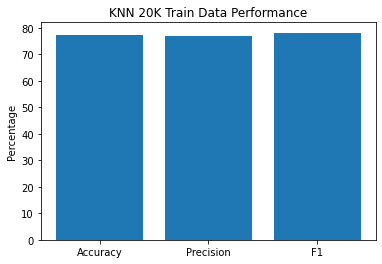

In [44]:
plt.xticks(ypos,y_perf_knn20k)
plt.ylabel("Percentage")
plt.title("KNN 20K Train Data Performance")
plt.bar(ypos,y_val_knn20k)

### 50K Training Data 10K Test Data

In [31]:
## KNN
# Start timer
K=223
temp = 'KNN classifier with K=' + str(K)
print(temp)
start = timeit.default_timer()
KNNclass = KNeighborsClassifier(n_neighbors=K, algorithm='kd_tree',
                                    weights='uniform', n_jobs=4)
KNNclass.fit(trainXpca, trainY)
y_pred = KNNclass.predict(testXpca)
# stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)
#Performance Measures
accuracy_knn50k = 100*accuracy_score(testY,y_pred)
precision_knn50k = 100*precision_score(testY,y_pred)
f1_knn50k = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_knn50k))
print("Precision: {:.04f}%".format(precision_knn50k))
print("F1 score: {:.04f}%".format(f1_knn50k))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

KNN classifier with K=223
Time:  75.80907750000188
Out of 10000 datapoints
Accuracy: 79.4800%
Precision: 80.0509%
F1 score: 79.9570%
Confusion Matrix: 
 [[3855 1020]
 [1032 4093]]


In [41]:
y_perf_knn50k = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_knn50k))
y_val_knn50k = np.array([accuracy_knn50k,precision_knn50k,f1_knn50k])

<BarContainer object of 3 artists>

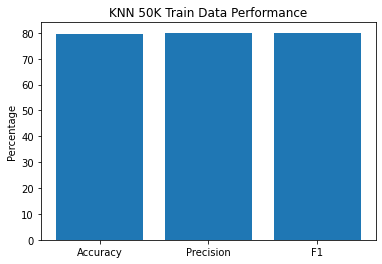

In [42]:
plt.xticks(ypos,y_perf_knn50k)
plt.ylabel("Percentage")
plt.title("KNN 50K Train Data Performance")
plt.bar(ypos,y_val_knn50k)

## 200K Training Data, 40K Test Data

In [46]:
## KNN
# Start timer
K=447
temp = 'KNN classifier with K=' + str(K)
print(temp)
start = timeit.default_timer()
KNNclass = KNeighborsClassifier(n_neighbors=K, algorithm='kd_tree',
                                    weights='uniform', n_jobs=4)
KNNclass.fit(trainXpca, trainY)
y_pred = KNNclass.predict(testXpca)
# stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)
#Performance Measures
accuracy_knn200k = 100*accuracy_score(testY,y_pred)
precision_knn200k = 100*precision_score(testY,y_pred)
f1_knn200k = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_knn200k))
print("Precision: {:.04f}%".format(precision_knn200k))
print("F1 score: {:.04f}%".format(f1_knn200k))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

KNN classifier with K=447
Time:  1314.1663139000011
Out of 40000 datapoints
Accuracy: 79.3225%
Precision: 78.2641%
F1 score: 80.1859%
Confusion Matrix: 
 [[14993  4648]
 [ 3623 16736]]


**So as can be seen in here increasing data numbers wont change the results too much but increasing running time exponentially. This depends on both number of data and K number.**

In [47]:
y_perf_knn200k = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_knn20k))
y_val_knn200k = np.array([accuracy_knn200k,precision_knn200k,f1_knn200k])

<BarContainer object of 3 artists>

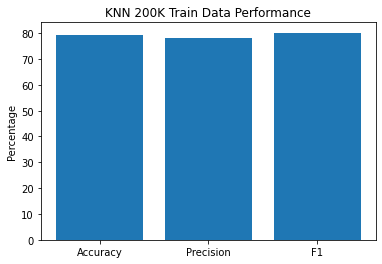

In [48]:
plt.xticks(ypos,y_perf_knn200k)
plt.ylabel("Percentage")
plt.title("KNN 200K Train Data Performance")
plt.bar(ypos,y_val_knn200k)

In [50]:
y_accu_knn = np.array(["20K","50K","200K"])
y_f1_knn = np.array(["20K","50K","200K"])
ypos = np.arange(len(y_accu_knn))
y_val_accuknn = np.array([accuracy_knn20k,accuracy_knn50k,accuracy_knn200k])
y_val_f1knn = np.array([f1_knn20k,f1_knn50k,f1_knn200k])

<BarContainer object of 3 artists>

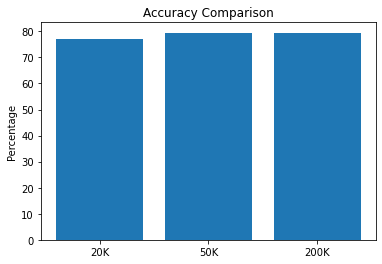

In [51]:
plt.xticks(ypos,y_accu_knn)
plt.ylabel("Percentage")
plt.title("Accuracy Comparison")
plt.bar(ypos,y_val_accuknn)

<BarContainer object of 3 artists>

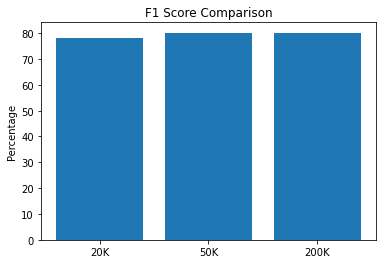

In [52]:
plt.xticks(ypos,y_f1_knn)
plt.ylabel("Percentage")
plt.title("F1 Score Comparison")
plt.bar(ypos,y_val_f1knn)

## References

Tan, P.-N., Steinbach, M., & Kumar, V. (2014). Introduction to Data Mining. Edinburgh: Pearson.


